In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [2]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## Layer Normalization

In [5]:
torch.manual_seed(567)

exm = torch.rand(2,5)
exm

tensor([[0.0241, 0.6811, 0.9764, 0.0148, 0.9654],
        [0.0947, 0.0031, 0.0631, 0.4348, 0.8750]])

In [6]:
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
output = layer(exm)
output

tensor([[0.0760, 0.5217, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4735, 0.6212, 0.0000, 0.0000, 0.2694, 0.0000]],
       grad_fn=<ReluBackward0>)

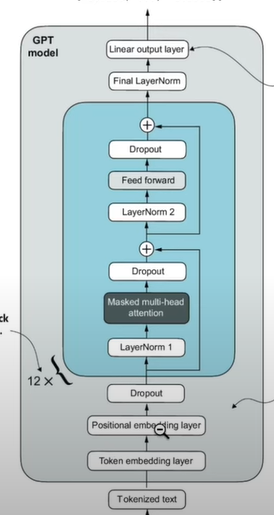

In [7]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        
        if len(token_ids) == max_length:
            input_chunk = token_ids
            target_chunk = token_ids[1:] + [token_ids[-1]]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
        elif len(token_ids) < max_length:
            padded_tokens = token_ids + [0] * (max_length - len(token_ids))
            input_chunk = padded_tokens
            target_chunk = padded_tokens[1:] + [0]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
        else:
            for i in range(0, len(token_ids) - max_length, stride):
                input_chunk = token_ids[i : i + max_length]
                target_chunk = token_ids[i + 1 : i + max_length + 1]
                self.input_ids.append(torch.tensor(input_chunk))
                self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=2, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    
    return dataloader    



raw_text = "Yours journey start with one steps"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = tokenizer.encode(raw_text, allowed_special={"<|endoftext|>"})

max_length = len(token_ids)
vocab_size = 50257
output_dim = 3

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
pos_embedding_layer = torch.nn.Embedding(max_length, output_dim)

dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=max_length,
    stride=max_length, shuffle=False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)

token_embeddings = token_embedding_layer(inputs)
pos_embeddings = pos_embedding_layer(torch.arange(max_length))

input_embeddings = token_embeddings + pos_embeddings
input_embeddings[0]


tensor([[-1.7276,  1.7185,  0.6178],
        [ 0.6030, -2.5155,  0.4160],
        [-2.6071, -1.2306,  1.1203],
        [-0.5879, -0.0948, -0.8682],
        [ 0.3462, -0.1653,  2.0449],
        [-1.4555,  1.1445,  1.7298],
        [-0.0403, -0.6876,  0.6450]], grad_fn=<SelectBackward0>)

In [8]:
import torch.nn as nn
class CausalAttention(nn.Module):
    
    def __init__(self, d_in, d_out, context_length, dropout):
        super().__init__()
        self.w_query = torch.nn.Linear(d_in, d_out, bias=False)
        self.w_key = torch.nn.Linear(d_in, d_out, bias=False)
        self.w_value = torch.nn.Linear(d_in, d_out, bias=False)
        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
        
    def forward(self, inputs):
        queries = self.w_query(inputs)
        keys = self.w_key(inputs)
        values = self.w_value(inputs)
        
        attn_scores = queries @ keys.transpose(-2, -1) 
        attn_scores = attn_scores.masked_fill(self.mask == 1, float('-inf'))
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context_vec = attn_weights @ values
        
        return context_vec

In [ ]:
import torch
import torch.nn as nn

class MultiHeadCausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads):
        super().__init__()
        assert d_out % num_heads == 0
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.heads = nn.ModuleList([
            CausalAttention(d_in, self.head_dim, context_length, dropout) 
            for _ in range(num_heads)
        ])

        self.out_proj = nn.Linear(d_out, d_out)
        
    def forward(self, inputs):
        head_outputs = [head(inputs) for head in self.heads]
        concatenated = torch.cat(head_outputs, dim=-1)
        output = self.out_proj(concatenated)
        return output

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, context_length, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadCausalAttention(
            d_in=d_model, 
            d_out=d_model, 
            context_length=context_length, 
            dropout=dropout, 
            num_heads=num_heads
        )
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        attn_out = self.attention(x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_out))
        
        return x

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, context_length, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length
        
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(context_length, d_model)
        
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, context_length, dropout)
            for _ in range(num_layers)
        ])
        
        self.final_norm = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        token_embeddings = self.token_embedding(input_ids)
        pos_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)
        pos_embeddings = self.pos_embedding(pos_ids)
        
        x = token_embeddings + pos_embeddings
        x = self.dropout(x)
        
        for block in self.transformer_blocks:
            x = block(x)
        
        x = self.final_norm(x)
        logits = self.lm_head(x)
        
        return logits

In [ ]:
raw_text = "Yours journey start with one steps"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = tokenizer.encode(raw_text, allowed_special={"<|endoftext|>"})


vocab_size = 50257  
d_model = 512       
num_heads = 8       
num_layers = 6      
d_ff = 2048        
context_length = len(token_ids)
dropout = 0.1


model = GPTModel(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    context_length=context_length,
    dropout=dropout
)


dataloader = create_dataloader_v1(
    raw_text, 
    batch_size=1, 
    max_length=context_length,
    stride=context_length, 
    shuffle=False
)


data_iter = iter(dataloader)
inputs, targets = next(data_iter)

print(f"Input shape: {inputs.shape}")
print(f"Input tokens: {inputs}")


model.eval()
with torch.no_grad():
    logits = model(inputs)
    
print(f"Output logits shape: {logits.shape}")
print(f"Logits for first token: {logits[0, 0, :10]}") 

predictions = torch.argmax(logits, dim=-1)
print(f"Predicted token IDs: {predictions}")

for i, pred_tokens in enumerate(predictions):
    decoded = tokenizer.decode(pred_tokens.tolist())
    print(f"Decoded prediction {i}: '{decoded}'")

Input shape: torch.Size([1, 7])
Input tokens: tensor([[  56, 4662, 7002,  923,  351,  530, 4831]])
Output logits shape: torch.Size([1, 7, 50257])
Logits for first token: tensor([-0.0373,  0.7171, -0.0947, -0.7409, -0.0386,  0.9929, -0.3154, -0.2998,
        -0.2837, -0.7172])
Predicted token IDs: tensor([[11793, 13521,  8767,  3820, 11399,   360, 13926]])
Decoded prediction 0: 'sur 1979alysisban Furthermore Deconom'
